In [1]:
import matplotlib.pyplot as plt
import numpy as np
from metamod.utils import QAnalysis
from sklearn.decomposition import PCA

Loading BokehJS ...

In [2]:
verbose = True
results_path = "../results/task_switch_main/slow_switch_run0_AffineCorrelatedGaussian_27-12-2022_20-36-08-225"
q_iters = 2000

In [3]:
qa = QAnalysis(results_path=results_path, verbose=verbose, q_iters=q_iters)

### Results from ../results/task_switch_main/slow_switch_run0_AffineCorrelatedGaussian_27-12-2022_20-36-08-225 ###
### Param Keys ###
--- dataset_params ---
dataset1_params, dataset2_params, dataset_classes, change_tasks_every, dataset
--- model_params ---
learning_rate, hidden_dim, intrinsic_noise, reg_coef, W1_0, W2_0, input_dim, output_dim, model
--- equation_params ---
in_cov, out_cov, in_out_cov, init_weights, n_steps, reg_coef, intrinsic_noise, learning_rate, change_task_every, time_constant, solver
--- control_params ---
control_lower_bound, control_upper_bound, gamma, cost_coef, reward_convertion, init_g, control_lr, in_cov, out_cov, in_out_cov, init_weights, n_steps, reg_coef, intrinsic_noise, learning_rate, change_task_every, time_constant, iters_control, control
--- reset_model_params ---
learning_rate, hidden_dim, intrinsic_noise, reg_coef, W1_0, W2_0, input_dim, output_dim, model
### Results Keys ###
dict_keys(['iters', 'Loss_t_sim', 'weights_sim', 'weights_iters_sim', 'ti

In [4]:
baseline_Q1, baseline_Q2, task_id_t =  qa.baseline_Q1, qa.baseline_Q2, qa.task_id_t.astype(bool)
control_Q1, control_Q2 = qa.control_Q1, qa.control_Q2
iters = qa.iters

In [5]:
def orthogonality_metric(Q1_t, Q2_t):
    metric = []
    for t_index in range(Q1_t.shape[0]):
        q = Q2_t[t_index, ...] @ Q1_t[t_index, ...]
        metric.append(np.sqrt((np.mean( (np.identity(q.shape[0]) - q)**2 ))))
    return np.array(metric)

In [6]:
baseline_metric = orthogonality_metric(baseline_Q1, baseline_Q2)
control_metric = orthogonality_metric(control_Q1, control_Q2)

baseline_metric1 = np.copy(baseline_metric)
baseline_metric1[task_id_t] = None
control_metric1 = np.copy(control_metric)
control_metric1[task_id_t] = None

baseline_metric2 = np.copy(baseline_metric)
baseline_metric2[np.logical_not(task_id_t)] = None
control_metric2 = np.copy(control_metric)
control_metric2[np.logical_not(task_id_t)] = None

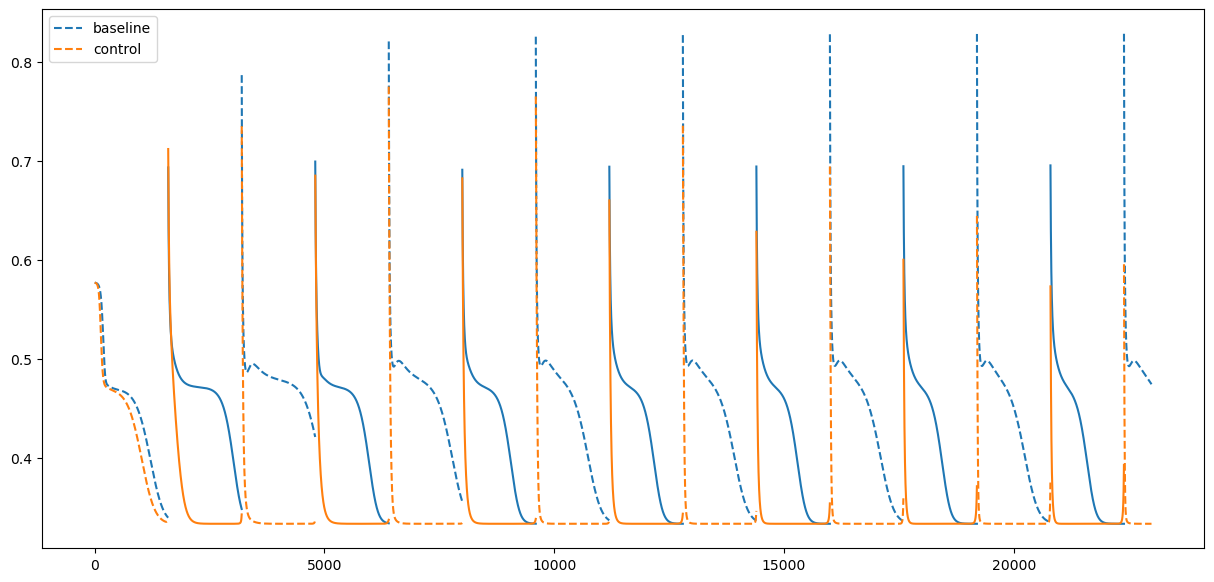

In [7]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(iters, baseline_metric1, "C0--", label="baseline")
ax.plot(iters, control_metric1, "C1--", label="control")
ax.plot(iters, baseline_metric2, "C0")
ax.plot(iters, control_metric2, "C1")
ax.legend()
plt.show()

In [8]:
all_Q1 = np.concatenate([baseline_Q1, control_Q1], axis=0)
all_Q1 = np.reshape(all_Q1, (all_Q1.shape[0], -1))

all_Q2 = np.concatenate([baseline_Q2, control_Q2], axis=0)
all_Q2 = np.reshape(all_Q2, (all_Q2.shape[0], -1))

In [9]:
pca1 = PCA(n_components=2).fit(all_Q1)
pca2 = PCA(n_components=2).fit(all_Q2)

In [10]:
baseline_Q1_proj = pca1.transform(np.reshape(baseline_Q1, (baseline_Q1.shape[0], -1)))
control_Q1_proj = pca1.transform(np.reshape(control_Q1, (control_Q1.shape[0], -1)))

In [11]:
baseline_Q2_proj = pca2.transform(np.reshape(baseline_Q2, (baseline_Q2.shape[0], -1)))
control_Q2_proj = pca2.transform(np.reshape(control_Q2, (control_Q2.shape[0], -1)))

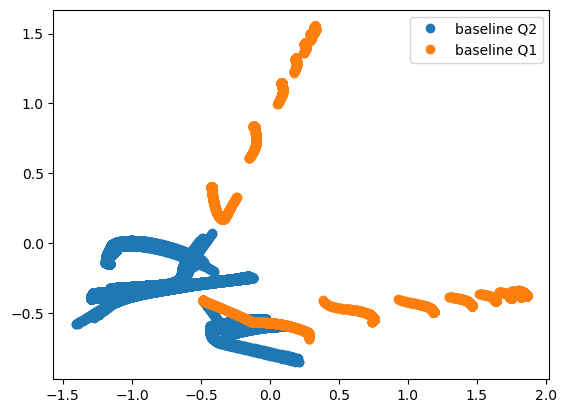

In [12]:
plt.plot(baseline_Q2_proj[:, 0], baseline_Q2_proj[:, 1], "o", label="baseline Q2")
plt.plot(control_Q2_proj[:, 0], control_Q2_proj[:, 1], "o", label="baseline Q1")
plt.legend()
plt.show()

In [13]:
Q12 = qa.sample_optimal_qs(qa.svd_task1, qa.cov_matrix_task2, n_qs=2)
Q21 = qa.sample_optimal_qs(qa.svd_task2, qa.cov_matrix_task1, n_qs=2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:56<00:00, 17.20it/s]


In [14]:
Q12_projected = pca2.transform(np.reshape(Q12, (Q12.shape[0], -1)))
Q21_projected = pca2.transform(np.reshape(Q21, (Q21.shape[0], -1)))

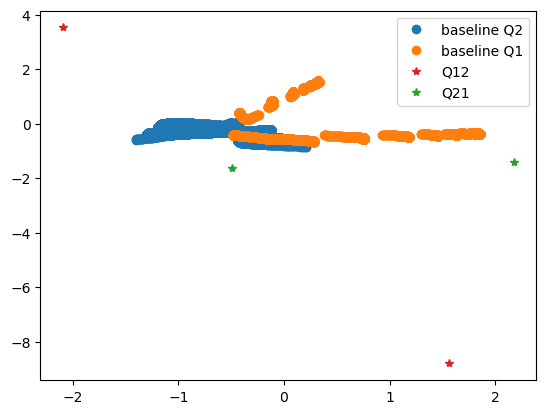

In [15]:
plt.plot(baseline_Q2_proj[:, 0], baseline_Q2_proj[:, 1], "o", label="baseline Q2")
plt.plot(control_Q2_proj[:, 0], control_Q2_proj[:, 1], "o", label="baseline Q1")
plt.plot(Q12_projected[:, 0], Q12_projected[:, 1], "C3*", label="Q12")
plt.plot(Q21_projected[:, 0], Q21_projected[:, 1], "C2*", label="Q21")
plt.legend()
plt.show()